## Barotropic streamfunction

Compared with data from [ColindeVerdiereOllitrault2016](https://doi.org/10.1175/JPO-D-15-0046.1)

Based on
https://github.com/OceansAus/cosima-cookbook/blob/master/ContributedExamples/BarotropicStreamFunction.ipynb

Set `ekey` below to plot different experiments.

In [1]:
%pylab inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt # to generate plots
import xarray as xr
import pandas as pd
import scipy.interpolate
import scipy.ndimage
from tqdm import tqdm_notebook
import IPython.display
import cmocean as cm
from scipy.io import loadmat
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cft
import matplotlib.ticker as mticker

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
# only retain 0.1deg
for key in list(exptdata.exptdict.keys()):
    if key is not '01deg':
        del exptdata.exptdict[key]
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

# session = cc.database.create_session()

Populating the interactive namespace from numpy and matplotlib
netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['01deg']


In [2]:
# define time intervals
times = [pd.to_datetime('1985', format='%Y')+pd.DateOffset(years=y) for y in range(0,34,4)]
# tstarts = times[0:-1]
# tends = times[1:]
tranges = list(zip(times[0:-1], times[1:]))
tranges.append((times[0],times[-1]))  # also do (almost) entire time range
yearranges = [str(pd.to_datetime(t[0]).year)+'-'+str(pd.to_datetime(t[1]).year-1) for t in tranges]
yearranges

['1985-1988',
 '1989-1992',
 '1993-1996',
 '1997-2000',
 '2001-2004',
 '2005-2008',
 '2009-2012',
 '2013-2016',
 '1985-2016']

In [4]:
figdir = ''
NOSYNC = 'NOSYNC/' # where to save figs we don't want to sync
if not os.path.exists(NOSYNC):
    os.makedirs(NOSYNC)
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=150, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

**The function below** calculates the quasi-barotropic streamfunction for each simulation. In each case, we read in only the last IAF cycle, then we average over the standard time period.

In [5]:
def get_gyre_psi(ekey):
    e = exptdata.exptdict[ekey]
    
    cntrl_tx_trans = cc.get_nc_variable(e['expt'],'ocean_month.nc','tx_trans_int_z',use_cache=True,
                                        n=e['n_files'],time_units=e['time_units'], offset=e['offset'])
    # convert from kg/s to Sv, assuming typical density of 1036kg/m^3 (underestimates deep ocean)
    cntrl_psi = cntrl_tx_trans.cumsum('yt_ocean')/1e6/1036
    #now find DP transport to subtract for the NAtl psi - see Rong
    cntrl_dp_ts = cntrl_psi.sel(xu_ocean=0,method='nearest').sel(yt_ocean=20,method='nearest')
    gyre_psi = -cntrl_psi+cntrl_dp_ts

    # write to disk
#     gyre_psi.to_netcdf(NOSYNC + expt + '_gyre_psi_' + yearrange +'.nc')
    
    return gyre_psi

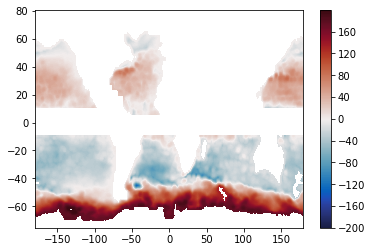

In [6]:
data=loadmat('/g/data3/hh5/tmp/cosima/observations/original/psi_barotropic.mat')
lon = data['lon_p'][0,:]
lat = data['lat_p'][0,:]
psi = data['psi']/1e6 # in Sv
plt.contourf(lon,lat,psi,levels=np.arange(-200,200),cmap = cm.cm.balance)
plt.colorbar()

In [7]:
aviso_file = '/g/data3/hh5/tmp/cosima/observations/original/AVISO_Mean_Std/aviso_ssh_monthly_anom_clim9314_GMSLtrend_removed.timstd.nc'
SLMA = xr.open_dataset(aviso_file).SLMA.mean('TAXM')

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


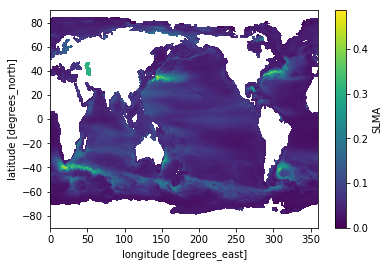

In [8]:
SLMA.plot()

In [9]:
obs_file = xr.open_dataset('/g/data3/hh5/tmp/cosima/observations/original/drifter_annualmeans.nc').rename({'Lat':'latitude','Lon':'longitude'})
obs_u = obs_file['U']
obs_v = obs_file['V']
# obs_lat = obs_file['latitude']
# obs_lon = obs_file['longitude']
obs_speed = np.sqrt(obs_u**2+obs_v**2).transpose()
# obs_speed = np.swapaxes(obs_speed,0,1)
del(obs_u, obs_v)

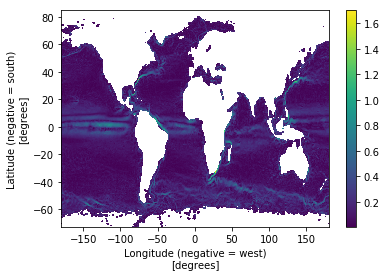

In [10]:
obs_speed.plot()

In [11]:
# General plotting stuff
# plot_labels=['(a) ','(b) ','(c) ','(d)']
land_50m = cft.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='black',
                                        facecolor='gray',
                                        linewidth=0.5)
# cmp = plt.get_cmap('gist_ncar_r')  # confusing with the most common form of colourblindness (deuteranomaly)
cmp = plt.get_cmap('nipy_spectral')

In [12]:
ekey = '01deg'
e = exptdata.exptdict[ekey]

sea_level = cc.get_nc_variable(e['expt'],'ocean_daily.nc','eta_t',use_cache=True,
                               n=e['n_files'],time_units=e['time_units'], offset=e['offset'])#\
    
sea_levelsq = cc.get_nc_variable(e['expt'],'ocean_month.nc','sea_levelsq',use_cache=True,
                                 n=e['n_files'],time_units=e['time_units'], offset=e['offset'])#\

u = cc.get_nc_variable(e['expt'], 'ocean.nc', 'u',use_cache=True,
                         n=e['n_files'],time_units=e['time_units'], offset=e['offset']).isel(st_ocean=0)
v = cc.get_nc_variable(e['expt'], 'ocean.nc', 'v',use_cache=True,
                         n=e['n_files'],time_units=e['time_units'], offset=e['offset']).isel(st_ocean=0)
speed_01deg = np.sqrt(u**2+v**2)  # wrong? - time-mean speed is not magnitude of time-mean velocity

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_daily.nc_eta_t_None_days-since-0001-01-01_None_False.pkl


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/cosima_cookbook/netcdf_index.py:391: UserWarning: ShareDict has been deprecated in favor of HighLevelGraph and will be removed in future versions
  return pickle.load(cachefile)


Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_sea_levelsq_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_u_None_days-since-0001-01-01_None_False.pkl
Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_v_None_days-since-0001-01-01_None_False.pkl


In [13]:
# gyre_psi_1deg = get_gyre_psi('1deg')
# gyre_psi_025deg = get_gyre_psi('025deg')
gyre_psi_01deg = get_gyre_psi('01deg')

Reading from cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean_month.nc_tx_trans_int_z_None_days-since-0001-01-01_None_False.pkl


In [27]:
hovlon = -72
speed_hov = speed_01deg.sel(xu_ocean=hovlon, method='nearest').sel(yu_ocean=slice(30,40)).transpose()

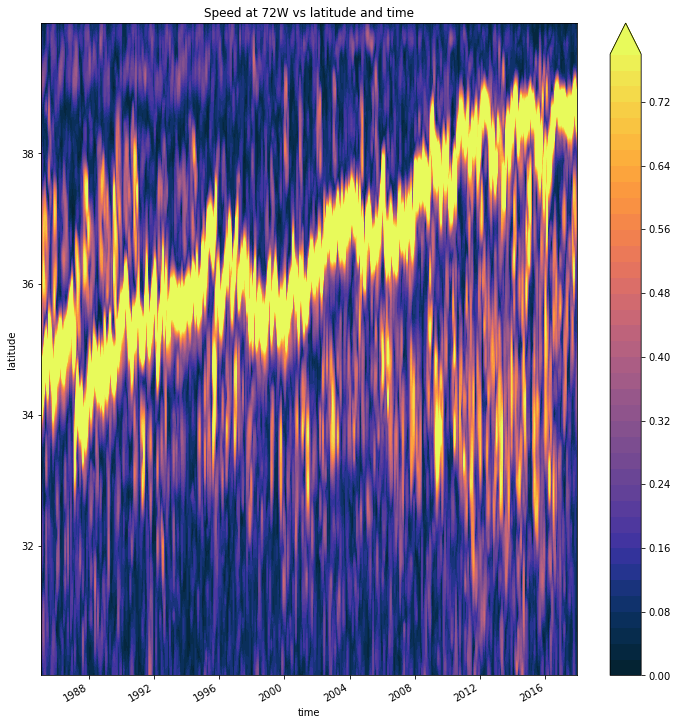

In [28]:
p1 = speed_hov.plot.contourf(cmap=cmp3, levels=clev3, extend='max')
p1.cmap.set_over(color=cmp3(255), alpha=None)
plt.ylabel('latitude')
plt.title('Speed at '+str(abs(hovlon))+'W vs latitude and time')
savefigure('gulfstream_speed_hovmoller')

In [14]:
# calculations for Gulf Stream region
# region = [-95, -5, 10, 65]  # minlon, maxlon, minlat, maxlat
# region = [-95, -40, 10, 50]  # minlon, maxlon, minlat, maxlat
region = [-90, -45, 15, 45]  # minlon, maxlon, minlat, maxlat

ekey = '01deg'

sea_level_gs   =   sea_level.sel(xt_ocean=slice(region[0], region[1])).sel(yt_ocean=slice(region[2], region[3]))
sea_levelsq_gs = sea_levelsq.sel(xt_ocean=slice(region[0], region[1])).sel(yt_ocean=slice(region[2], region[3]))

gyre_psi_01deg_gs = gyre_psi_01deg.sel(xu_ocean=slice(region[0], region[1])).sel(yt_ocean=slice(region[2], region[3]))

speed_gs = speed_01deg.sel(xu_ocean=slice(region[0], region[1])).sel(yu_ocean=slice(region[2], region[3]))
obs_speed_gs = obs_speed.sel(longitude=slice(region[0], region[1])).sel(latitude=slice(region[2], region[3]))

sla_rmss = []
gyre_psis = []
speeds = []

for i, trange in enumerate(tranges):
    print(yearranges[i])
    sea_level_gs_mean   =   sea_level_gs.sel(time=slice(trange[0], trange[1])).mean('time')
    sea_levelsq_gs_mean = sea_levelsq_gs.sel(time=slice(trange[0], trange[1])).mean('time')
    sla_rms = (sea_levelsq_gs_mean - sea_level_gs_mean**(2.0))**(0.5)
    sla_rmss.append(sla_rms.load())
    gyre_psis.append(gyre_psi_01deg_gs.sel(time=slice(trange[0], trange[1])).mean('time').load())
    speeds.append(speed_gs.sel(time=slice(trange[0], trange[1])).mean('time').load())

1985-1988


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/array/numpy_compat.py:28: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


1989-1992
1993-1996
1997-2000
2001-2004
2005-2008
2009-2012
2013-2016
1985-2016


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/seaborn/apionly.py:9: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


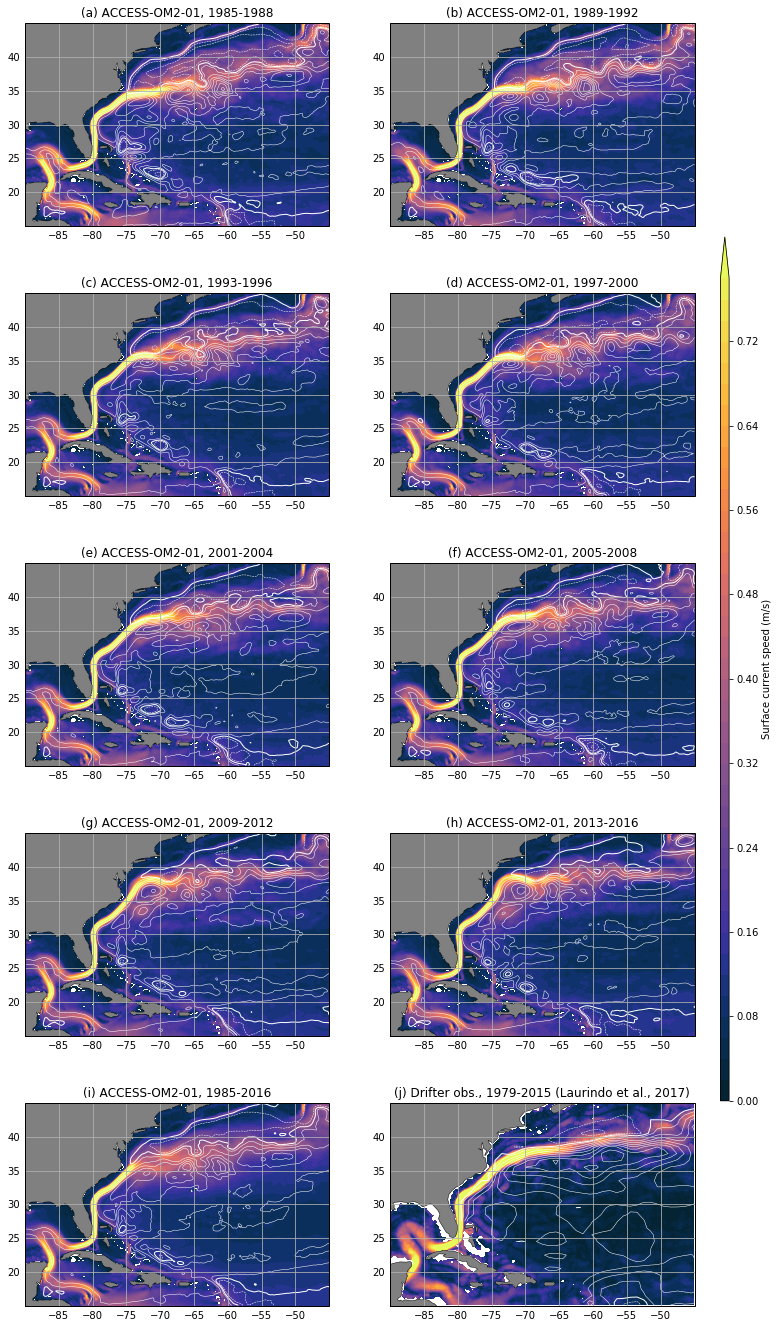

In [15]:
# barotropic streamfunction and speed plots for Gulf Stream region

plt.figure(figsize(12,24))
# clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,75.01,10)
clev3 = np.arange(0,0.8,0.02)
cmp3 = cm.cm.thermal

for i in range(len(speeds)):
    speed  =  speeds[i]
    gyre_psi = gyre_psis[i]
    
    ax = plt.subplot((len(speeds)+1)//2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent(region, crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
    gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=speed.plot.contourf(cmap=cmp3, levels=clev3, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp3(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title('('+chr(i+ord('a'))+') '+exptdata.exptdict[ekey]['desc']+', '+yearranges[i])

# now plot obs
i = i+1

ax = plt.subplot((len(speeds)+1)//2,2,i+1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent(region, crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])

gl.xlabels_top = False
gl.ylabels_right = False
p1=obs_speed_gs.plot.contourf(cmap=cmp3, levels=clev3, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp3(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('('+chr(i+ord('a'))+') '+'Drifter obs., 1979-2015 (Laurindo et al., 2017)')

ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Surface current speed (m/s)')
savefigure('gulfstream_speed')

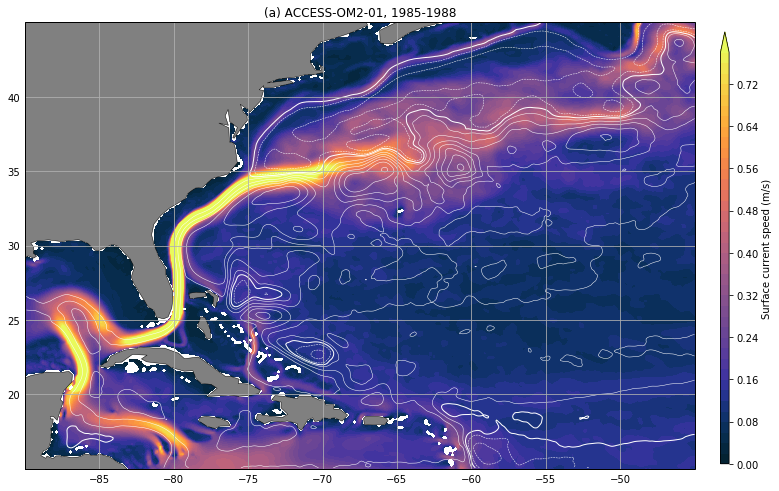

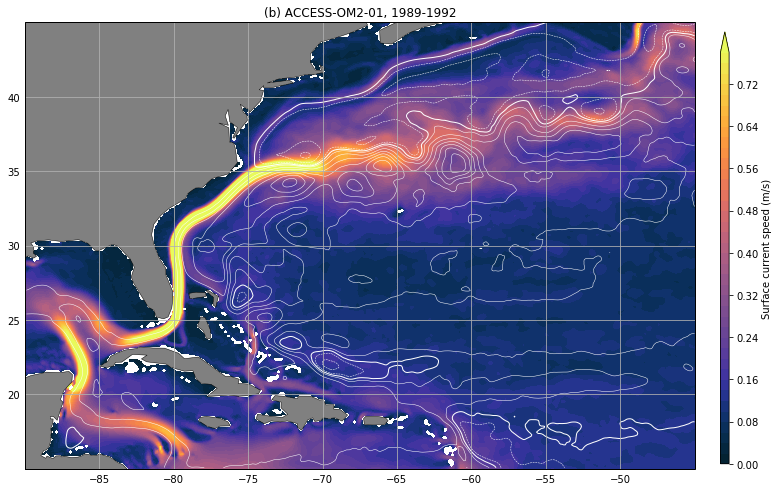

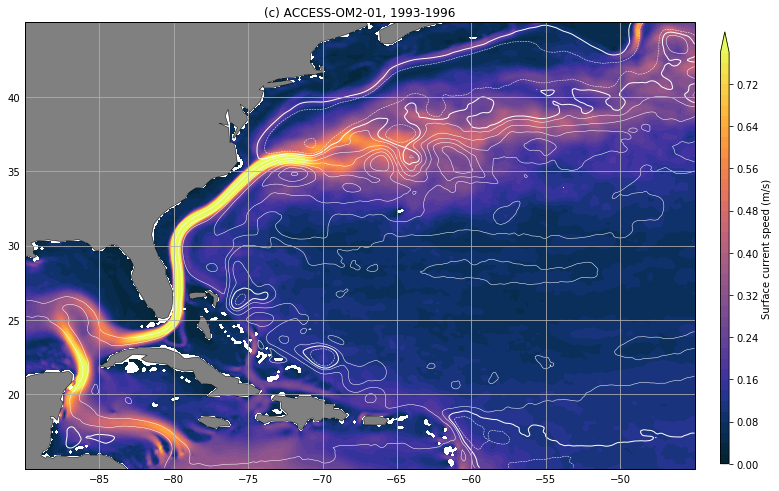

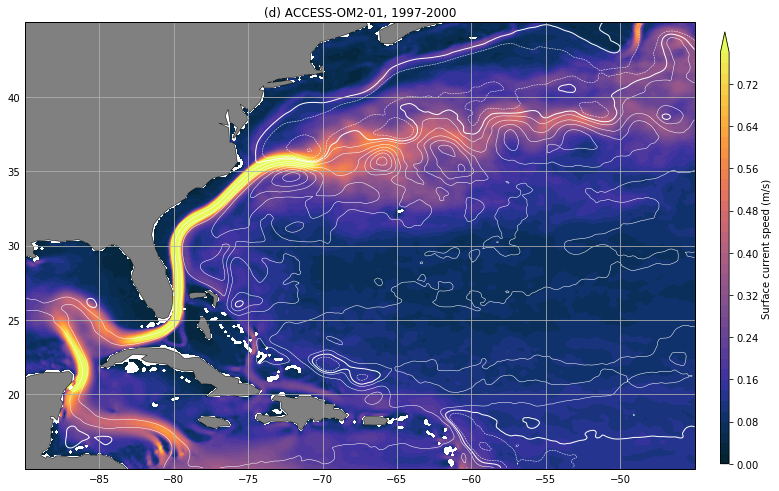

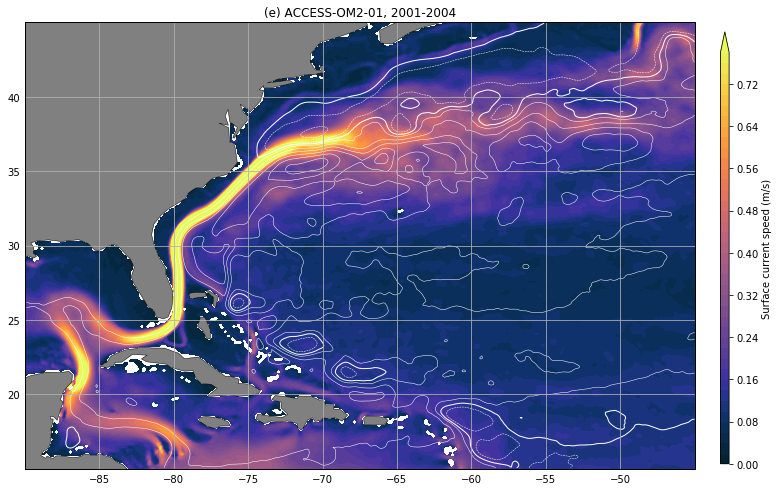

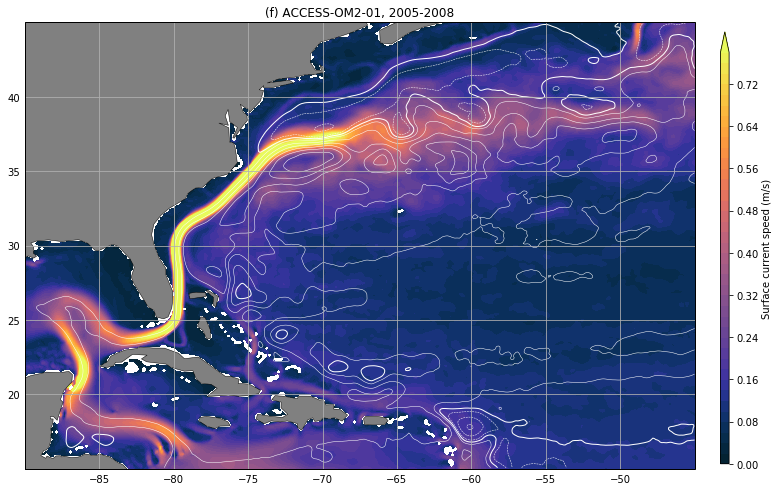

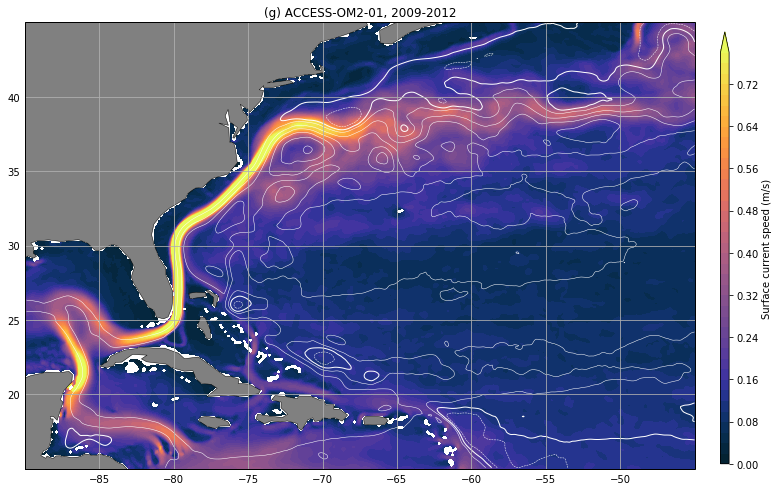

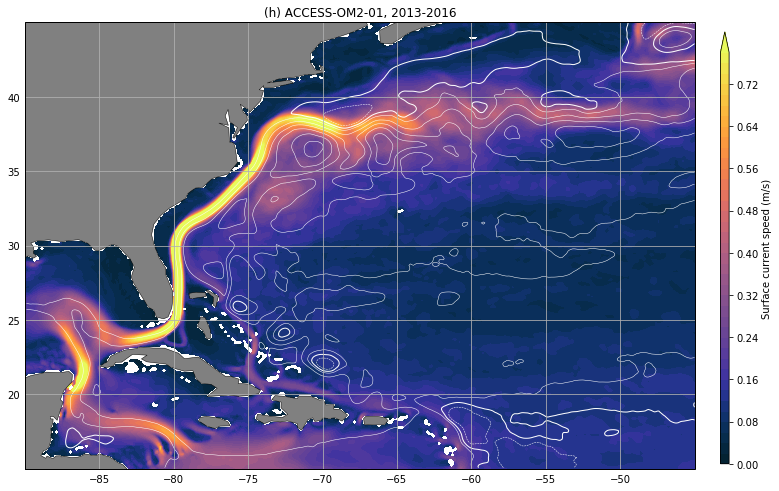

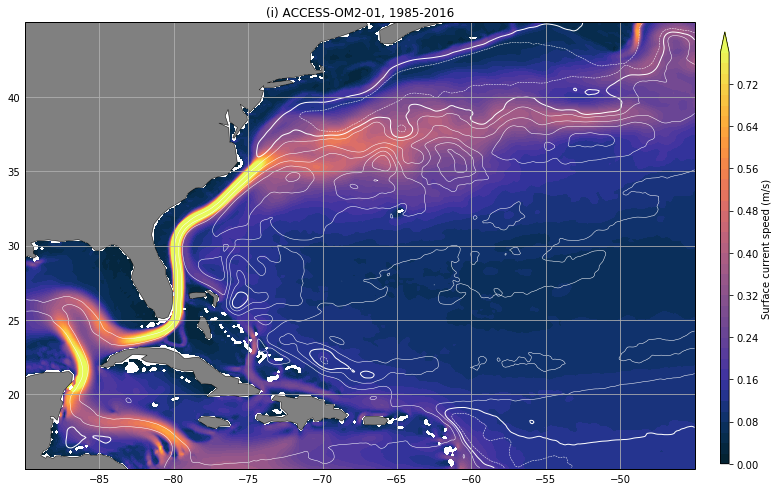

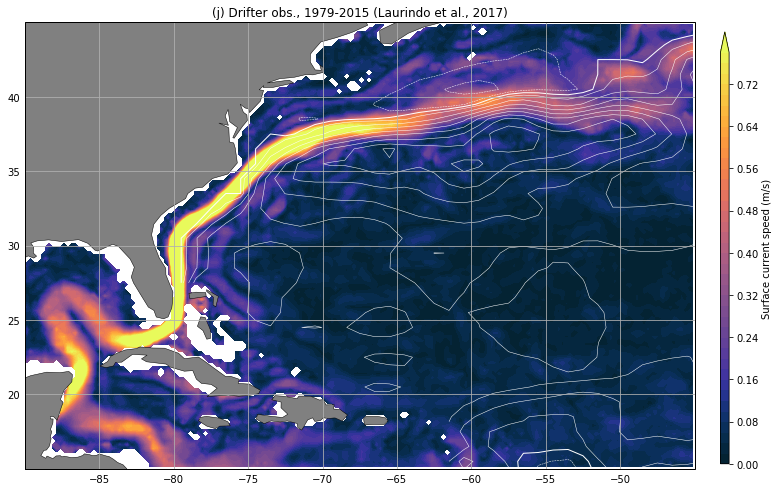

In [16]:
# multi-file barotropic streamfunction and speed plots for Gulf Stream region

# clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,75.01,10)
clev3 = np.arange(0,0.8,0.02)
cmp3 = cm.cm.thermal

for i in range(len(speeds)):
    plt.figure(figsize(12,12))
    speed  =  speeds[i]
    gyre_psi = gyre_psis[i]
    
    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent(region, crs=ccrs.PlateCarree())
#     ax.set_axis_bgcolor('gray')
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
    gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=speed.plot.contourf(cmap=cmp3, levels=clev3, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp3(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title('('+chr(i+ord('a'))+') '+exptdata.exptdict[ekey]['desc']+', '+yearranges[i])
    
    ax3 = plt.axes([0.93,0.25,0.01,0.5])
    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('Surface current speed (m/s)')
    savefigure('gulfstream_speed_'+yearranges[i])

# now plot obs
i = i+1
plt.figure(figsize(12,12))

ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent(region, crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])

gl.xlabels_top = False
gl.ylabels_right = False
p1=obs_speed_gs.plot.contourf(cmap=cmp3, levels=clev3, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp3(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('('+chr(i+ord('a'))+') '+'Drifter obs., 1979-2015 (Laurindo et al., 2017)')

ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Surface current speed (m/s)')
savefigure('gulfstream_speed_obs')

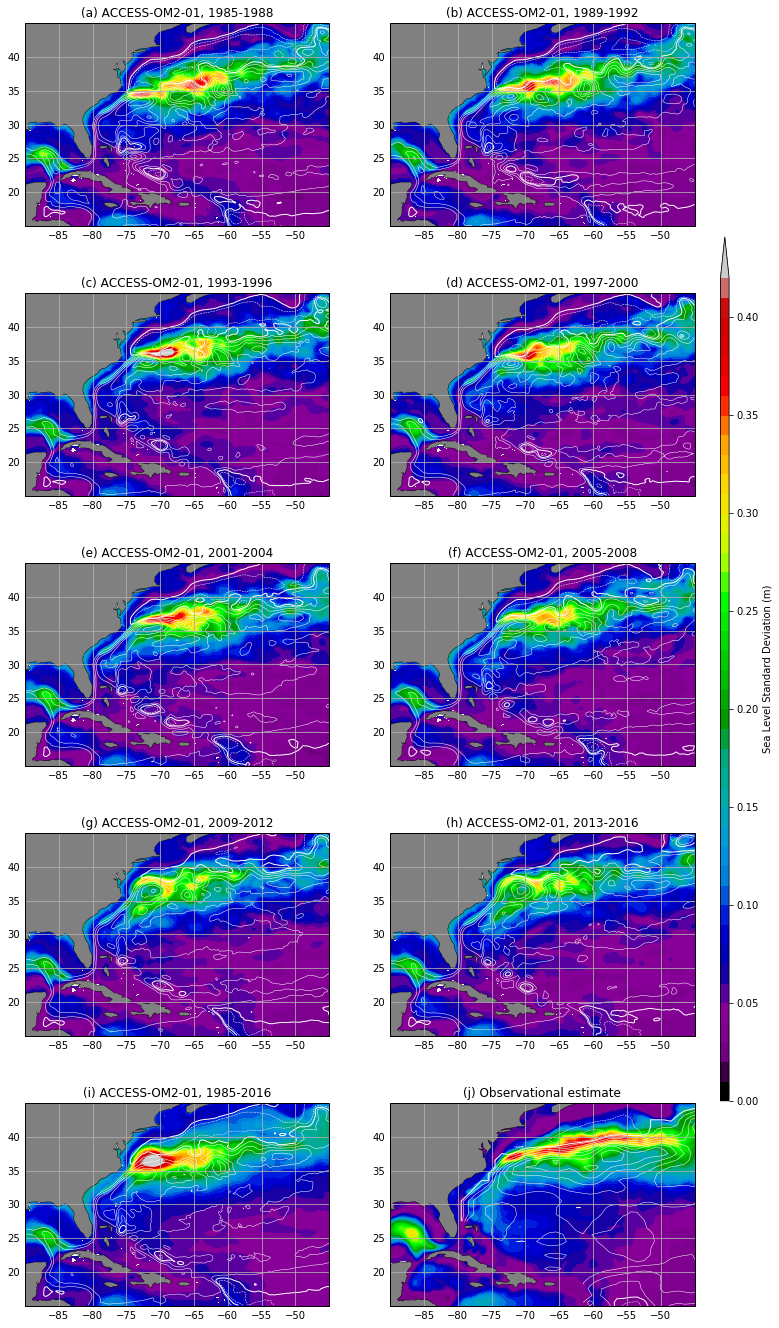

In [17]:
# barotropic streamfunction and variability plots for Gulf Stream region

plt.figure(figsize(12,24))
clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,75.01,10)

for i in range(len(sla_rmss)):
    sla_rms  =  sla_rmss[i]
    gyre_psi = gyre_psis[i]
    
    ax = plt.subplot((len(sla_rmss)+1)//2,2,i+1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent(region, crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
    gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title('('+chr(i+ord('a'))+') '+exptdata.exptdict[ekey]['desc']+', '+yearranges[i])
    

# now plot obs
i = i+1

ax = plt.subplot((len(sla_rmss)+1)//2,2,i+1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent(region, crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])

gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('('+chr(i+ord('a'))+') '+'Observational estimate')

ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
savefigure('gulfstream_variability')

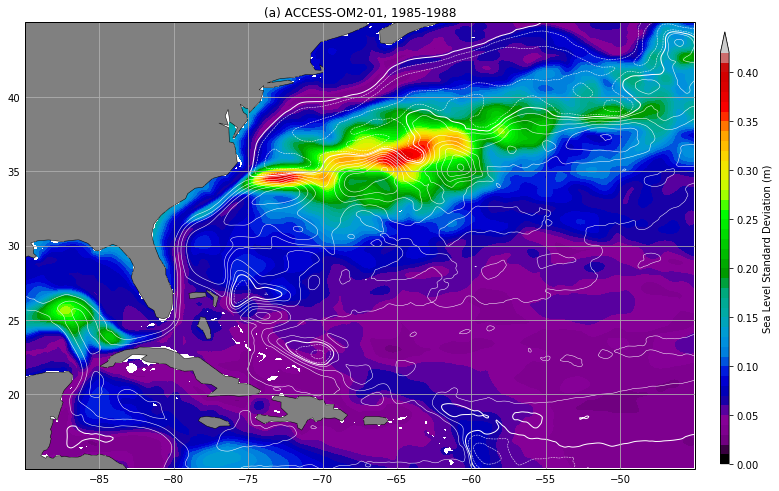

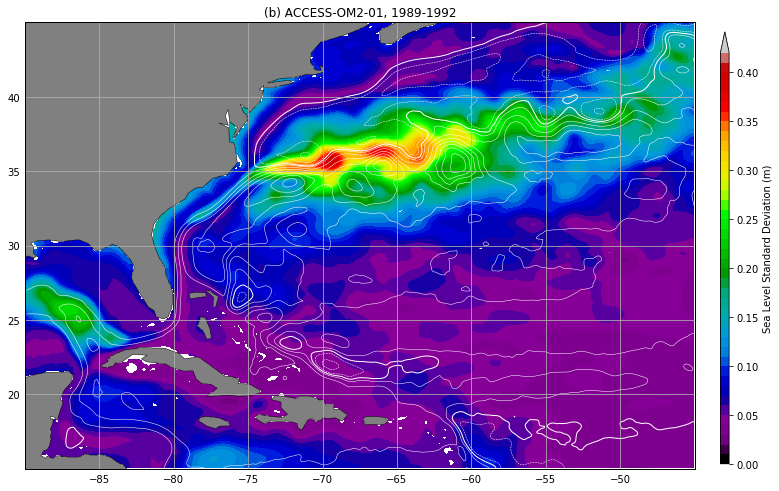

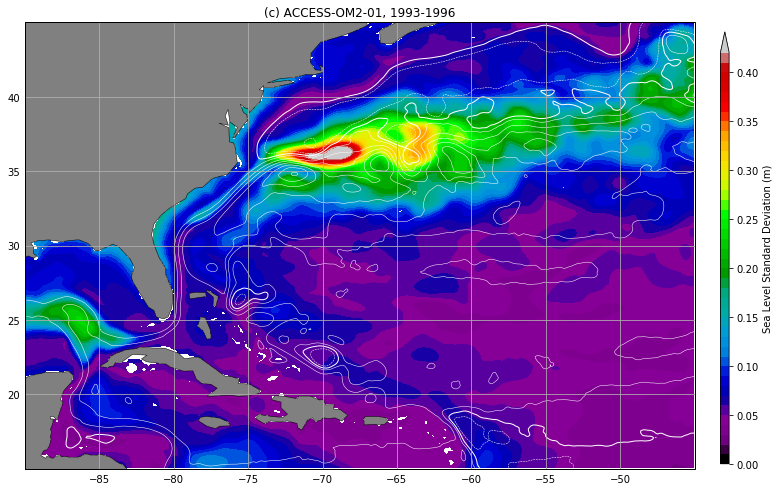

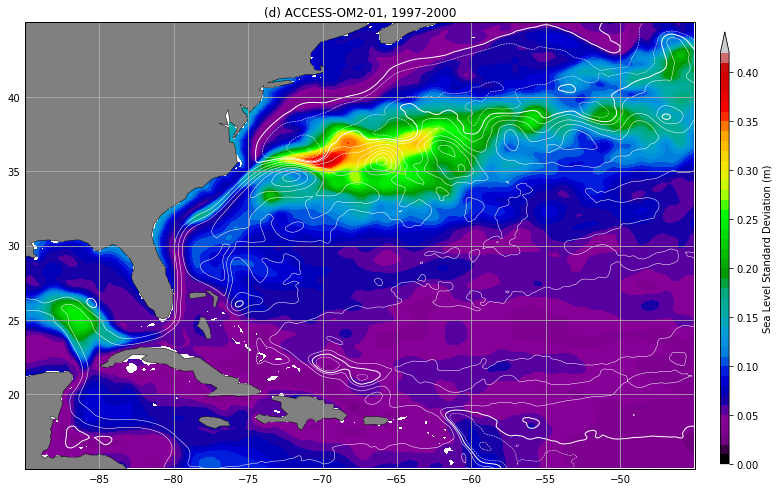

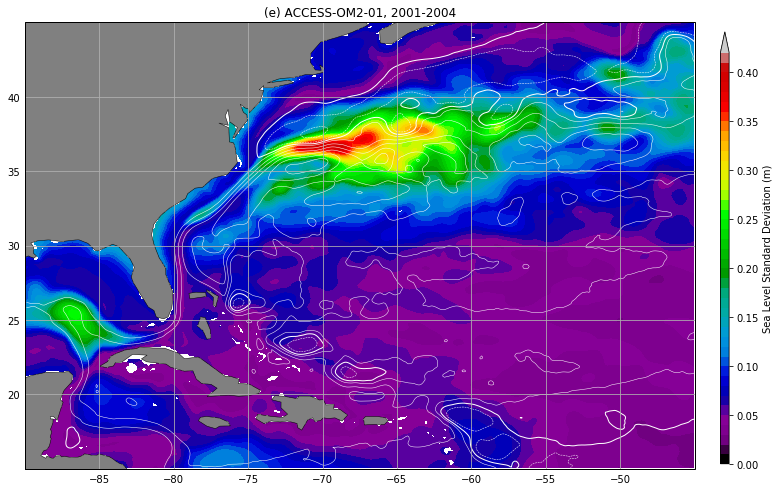

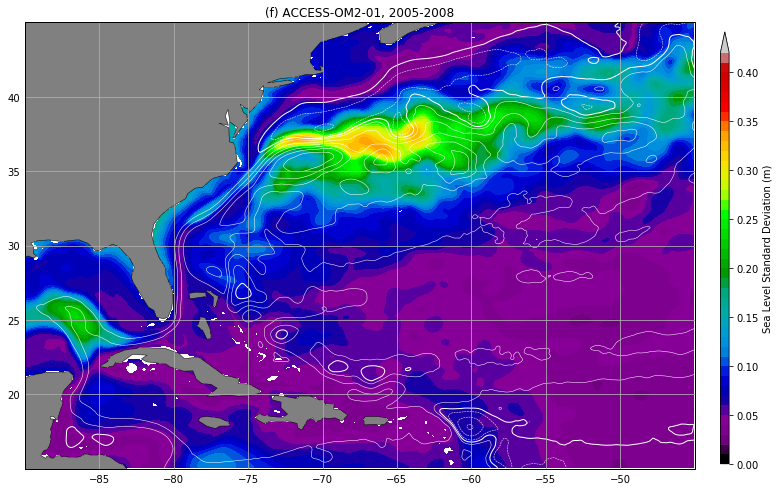

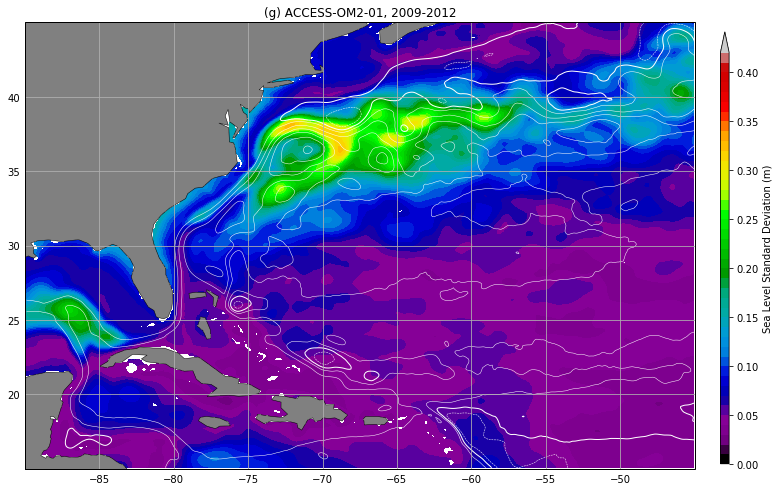

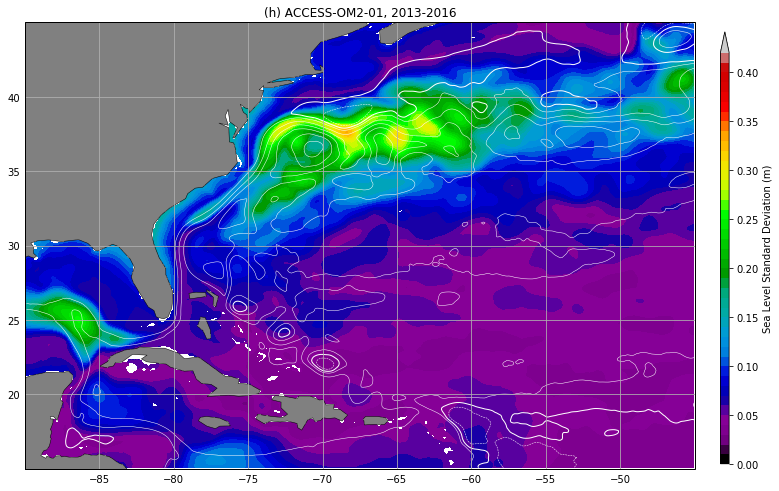

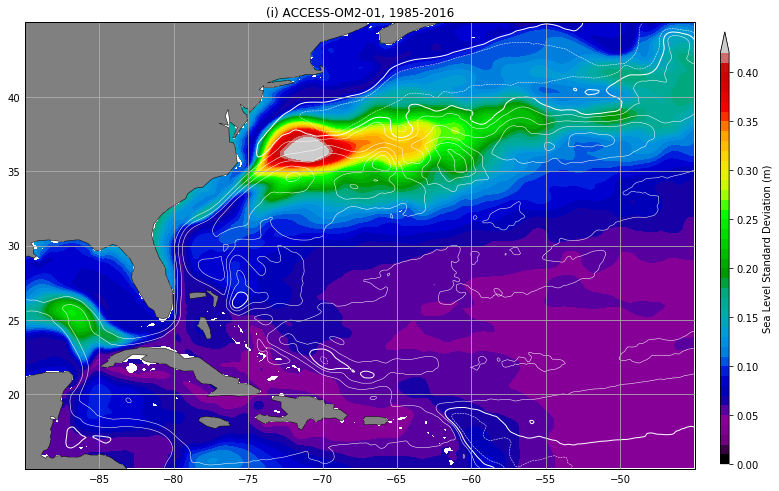

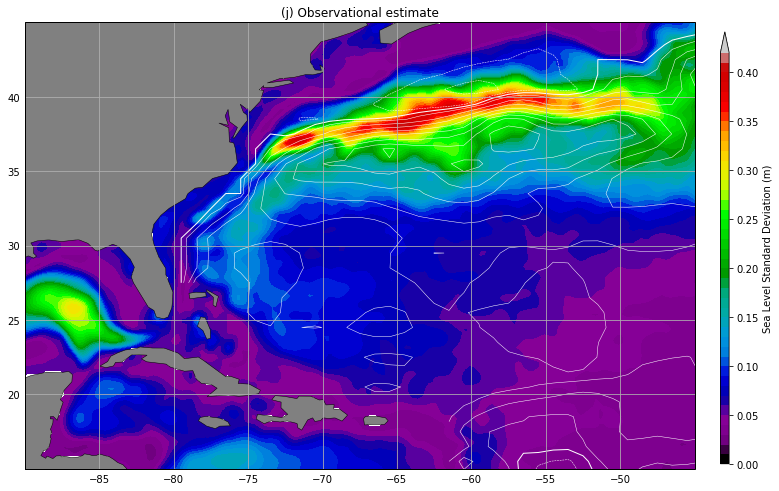

In [18]:
# multi-file barotropic streamfunction and variability plots for Gulf Stream region

clev = np.arange(0,0.421,0.01)
clev2 = np.arange(-75,75.01,10)

for i in range(len(sla_rmss)):
    plt.figure(figsize(12,12))

    sla_rms  =  sla_rmss[i]
    gyre_psi = gyre_psis[i]
    
    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
    ax.add_feature(land_50m)
    ax.set_extent(region, crs=ccrs.PlateCarree())
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
    gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
    gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    p1=sla_rms.plot.contourf(cmap=cmp, levels=clev, extend='max', 
                              add_colorbar=False, transform=ccrs.PlateCarree()) 
    p1.cmap.set_over(color=cmp(255), alpha=None)
    gyre_psi.plot.contour(levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
    gyre_psi.plot.contour(levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
    plt.title('('+chr(i+ord('a'))+') '+exptdata.exptdict[ekey]['desc']+', '+yearranges[i])
    
    ax3 = plt.axes([0.93,0.25,0.01,0.5])
    cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
    cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
    savefigure('gulfstream_variability_'+yearranges[i])

# now plot obs
i = i+1
plt.figure(figsize(12,12))

ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
ax.add_feature(land_50m)
ax.set_extent(region, crs=ccrs.PlateCarree())
    
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.xlocator = mticker.FixedLocator(range(region[0], region[1]+1, 5)) #[-95, -90, -70, -50, -30, -10, -5])
gl.ylocator = mticker.FixedLocator(range(region[2], region[3]+1, 5)) #[10, 15, 25, 35, 45, 55, 65])

gl.xlabels_top = False
gl.ylabels_right = False
p1=SLMA.plot.contourf(cmap=cmp, levels=clev, extend='max', add_colorbar=False, transform=ccrs.PlateCarree()) 
p1.cmap.set_over(color=cmp(255), alpha=None)
plt.contour(lon,lat,psi,levels=clev2,colors='w',linewidths=0.5,transform=ccrs.PlateCarree())
plt.contour(lon,lat,psi,levels=[0.0,],colors='w',linewidths=1.0,transform=ccrs.PlateCarree())
plt.title('('+chr(i+ord('a'))+') '+'Observational estimate')

ax3 = plt.axes([0.93,0.25,0.01,0.5])
cb = plt.colorbar(p1,cax=ax3,orientation='vertical')
cb.ax.set_ylabel('Sea Level Standard Deviation (m)')
savefigure('gulfstream_variability_obs')